## Olympic Medal and Emerging Athlete Pedictor

The Olympic Games is the world’s top sports competition, with 206 nations and over 14,000 athletes taking part in various summer and winter sports.​ Olympic outcomes can be very unpredictable where it can be difficult to predict future medalists. We created an accuracte predictive model that can help athletes, coaches, and sports organizations properly identify current stars while also developing future talent. Likewise, competitive athletes and amateurs alike are interested in predicting wins and potential break-out athletes that could be their fierest competitiers. 

In [28]:

# Import libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## Data Preprocessing and EDA
We load in our data to prepare the dataset for further analysis by handling missing values, converting categorical variables, and creating additional features for predicitve modeling. We also provide initial insights into the dataset's characteristics and structure through descriptive statistics and sample data. 

In [29]:
# Load in dataset
athlete_events = pd.read_csv('athlete_events.csv')

# Calculate median values for each column
age_median = athlete_events['Age'].mean()
height_median = athlete_events['Height'].mean()
weight_median = athlete_events['Weight'].mean()

# Fill missing values with median values
athlete_events['Age'] = athlete_events['Age'].fillna(age_median)
athlete_events['Height'] = athlete_events['Height'].fillna(height_median)
athlete_events['Weight'] = athlete_events['Weight'].fillna(weight_median)

# Convert categorical columns to numeric
athlete_events['Sex'] = athlete_events['Sex'].map({'F': 1, 'M': 0}).astype(int)
athlete_events['Season'] = athlete_events['Season'].map({'Summer': 0, 'Winter': 1}).astype(int)

# Add new columns to predict future winners and break out athletes
athlete_events['won_medal'] = athlete_events['Medal'].notnull().astype(int)
athlete_events['participated_before'] = athlete_events.duplicated(subset=['Name'], keep=False)
athlete_events['won_medal_before'] = athlete_events.groupby('Name')['won_medal'].transform('max')
athlete_events['breakout_candidate'] = ((athlete_events['participated_before'] == True) & (athlete_events['won_medal_before'] == 0)).astype(int)

# Describe the dataset
print("\nDescription of the dataset:")
print(athlete_events.describe())

# Show the shape of the dataset
print("\nShape of the dataset:")
print(athlete_events.shape)

# Show the first 5 rows of the dataset
athlete_events.head()


Description of the dataset:
                  ID            Sex            Age        Height  \
count  271116.000000  271116.000000  271116.000000  271116.00000   
mean    68248.954396       0.274871      25.556898     175.33897   
std     39022.286345       0.446450       6.280857       9.27810   
min         1.000000       0.000000      10.000000     127.00000   
25%     34643.000000       0.000000      22.000000     170.00000   
50%     68205.000000       0.000000      25.000000     175.33897   
75%    102097.250000       1.000000      28.000000     180.00000   
max    135571.000000       1.000000      97.000000     226.00000   

              Weight           Year         Season      won_medal  \
count  271116.000000  271116.000000  271116.000000  271116.000000   
mean       70.702393    1978.378480       0.179126       0.146738   
std        12.574690      29.877632       0.383459       0.353845   
min        25.000000    1896.000000       0.000000       0.000000   
25%        63

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,won_medal,participated_before,won_medal_before,breakout_candidate
0,1,A Dijiang,0,24.0,180.00000,80.000000,China,CHN,1992 Summer,1992,0,Barcelona,Basketball,Basketball Men's Basketball,NaN,0,False,0,0
1,2,A Lamusi,0,23.0,170.00000,60.000000,China,CHN,2012 Summer,2012,0,London,Judo,Judo Men's Extra-Lightweight,NaN,0,False,0,0
2,3,Gunnar Nielsen Aaby,0,24.0,175.33897,70.702393,Denmark,DEN,1920 Summer,1920,0,Antwerpen,Football,Football Men's Football,NaN,0,False,0,0
3,4,Edgar Lindenau Aabye,0,34.0,175.33897,70.702393,Denmark/Sweden,DEN,1900 Summer,1900,0,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,1,False,1,0
4,5,Christine Jacoba Aaftink,1,21.0,185.00000,82.000000,Netherlands,NED,1988 Winter,1988,1,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,0,True,0,1


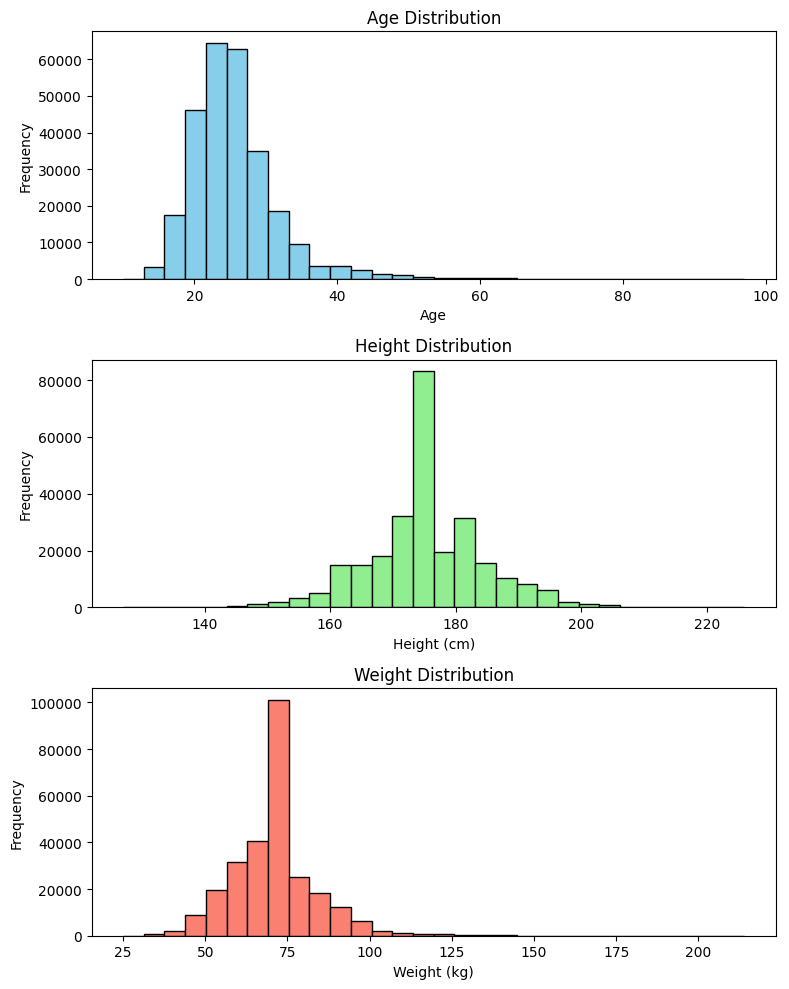

In [30]:
# Plot age, height and weight distributions
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# Age distribution
axes[0].hist(athlete_events['Age'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Height distribution
axes[1].hist(athlete_events['Height'], bins=30, color='lightgreen', edgecolor='black')
axes[1].set_title('Height Distribution')
axes[1].set_xlabel('Height (cm)')
axes[1].set_ylabel('Frequency')

# Weight distribution
axes[2].hist(athlete_events['Weight'], bins=30, color='salmon', edgecolor='black')
axes[2].set_title('Weight Distribution')
axes[2].set_xlabel('Weight (kg)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Machine Learning Models - Predicting Possible Olmpyic Game Winners and Break Out Athletes
We decided on using the Logisitic Regression Classifer, Decision Tree, and Random Forest machine learning models to predict the likelihood that athletes are winning medals.


In [31]:
# Parameters and Models for GridSearchCV
# Hyperparameters for Logistic Regression
logisticRegression_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
}

# Hyperparameters for Decision Tree
decisisonTree_params = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2']
}

# Hyperparameters for Random Forest
randomForest_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Our Models
# Initialize models with GridSearchCV
models = {
    'Logistic Regression': GridSearchCV(LogisticRegression(), param_grid=logisticRegression_params, cv=5),
    'Decision Tree': GridSearchCV(DecisionTreeClassifier(), param_grid=decisisonTree_params, cv=5),
    'Random Forest': GridSearchCV(RandomForestClassifier(), param_grid=randomForest_params, cv=5)
}

## Predicting Model Wins 
We are performing model evaluation and selection for predicting whether an athlete will win a medal in a sporting event based on features such as age, height, weight, sex, and season. We split the dataset into training and test sets, scale the features, and then train multiple models using GridSearchCV to find the best hyperparameters. Finally, we evaluate the models using metrics like accuracy, F1 score, precision, and recall, and visualize the feature importances of the best-performing model.

Logistic Regression:
  Best Parameters: {'C': 0.001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
  Best Score: 0.85
  Accuracy: 0.85
  F1 Score: 0.85
  Precision: 0.85
  Recall: 0.85


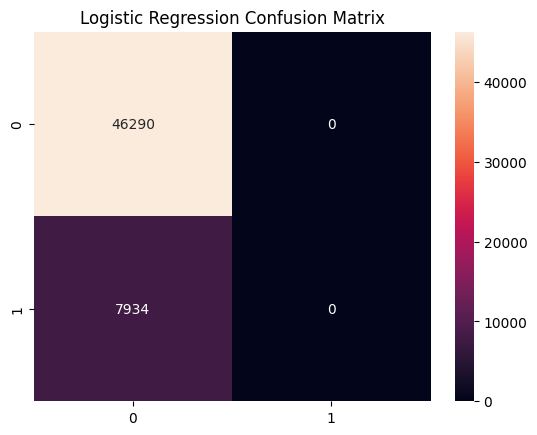

Decision Tree:
  Best Parameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5}
  Best Score: 0.85
  Accuracy: 0.85
  F1 Score: 0.85
  Precision: 0.85
  Recall: 0.85


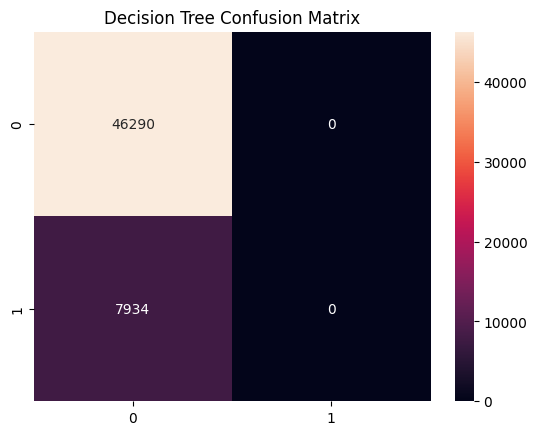

Random Forest:
  Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
  Best Score: 0.85
  Accuracy: 0.85
  F1 Score: 0.85
  Precision: 0.85
  Recall: 0.85


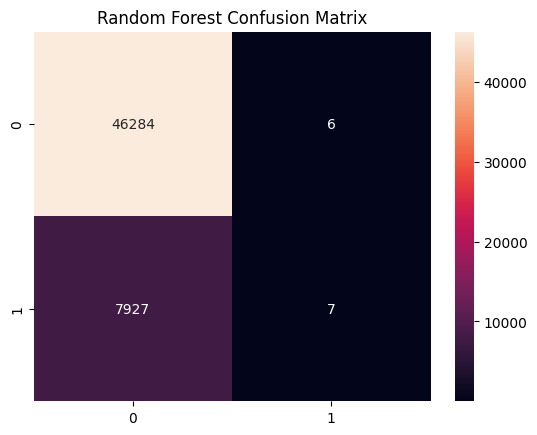


Best Model: Random Forest
Best Model Accuracy: 0.85
Best Model F1 Score: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     46290
           1       0.50      0.00      0.00      7934

    accuracy                           0.85     54224
   macro avg       0.68      0.50      0.46     54224
weighted avg       0.80      0.85      0.79     54224



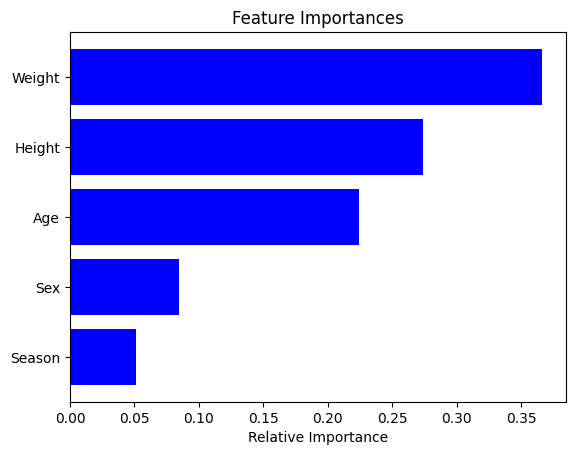

In [32]:
# Data for modeling
features = ['Age', 'Height', 'Weight', 'Sex', 'Season']
X = athlete_events[features]
y = athlete_events['won_medal']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Model evaluation
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    print(f"{name}:")
    print(f"  Best Parameters: {model.best_params_}")
    print(f"  Best Score: {model.best_score_:.2f}")

    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='micro')

    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")                               
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
# Get the best model
best_model_name = max(models, key=lambda k: models[k].best_score_)
best_model = models[best_model_name].best_estimator_

# Evaluate the best model
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='micro')
classification_report_best = classification_report(y_test, y_pred_best)

print(f"\nBest Model: {best_model_name}")
print(f"Best Model Accuracy: {accuracy_best:.2f}")
print(f"Best Model F1 Score: {f1_best:.2f}")
print(f"Classification Report:\n{classification_report_best}")

# Feature Importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## Breakout Athletes 
We aim to predict breakout athletes by training machine learning models on features such as age, height, weight, sex, and season. The dataset is split into training and test sets, scaled using StandardScaler, and evaluated using various classification models. The best-performing model is then used to predict breakout candidates and their probabilities, and feature importances are visualized to understand the importance of each feature in predicting breakout athletes.

Logistic Regression:
  Best Parameters: {'C': 0.01, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}
  Best Score: 0.56
  Accuracy: 0.56
  F1 Score: 0.56
  Precision: 0.56
  Recall: 0.56
Decision Tree:
  Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
  Best Score: 0.58
  Accuracy: 0.58
  F1 Score: 0.58
  Precision: 0.58
  Recall: 0.58
Random Forest:
  Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best Score: 0.63
  Accuracy: 0.64
  F1 Score: 0.64
  Precision: 0.64
  Recall: 0.64

Best Model for Breakout Candidates: Random Forest
Best Model Accuracy: 0.64
Best Model F1 Score: 0.64
Classification Report for Breakout Candidates:
              precision    recall  f1-score   support

           0       0.63      0.75      0.69     28335
           1       0.66      0.52      0.58     25889

    accuracy                           0.64     542

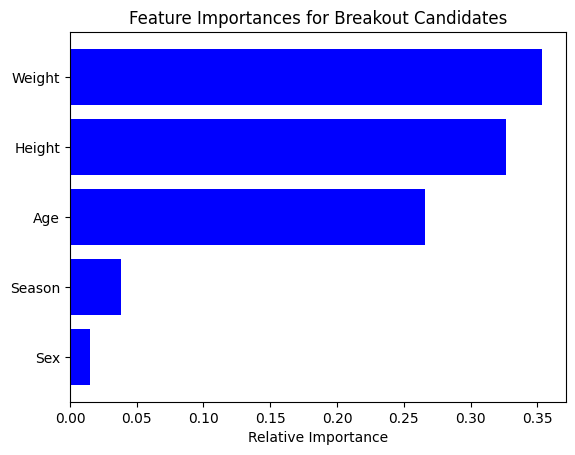

In [33]:
# Define Features and Target for predicting breakout athletes
X_breakout = athlete_events[features]
y_breakout = athlete_events['breakout_candidate'] 

# Split the data into training and test sets
X_train_breakout, X_test_breakout, y_train_breakout, y_test_breakout = train_test_split(X_breakout, y_breakout, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled_breakout = scaler.fit_transform(X_train_breakout)
X_test_scaled_breakout = scaler.transform(X_test_breakout)

# Model evaluation
for name, model in models.items():
    model.fit(X_train_scaled_breakout, y_train_breakout)
    print(f"{name}:")
    print(f"  Best Parameters: {model.best_params_}")
    print(f"  Best Score: {model.best_score_:.2f}")

    y_pred_breakout = model.predict(X_test_scaled_breakout)
    accuracy_breakout = accuracy_score(y_test_breakout, y_pred_breakout)
    f1_breakout = f1_score(y_test_breakout, y_pred_breakout, average='micro')
    precision_breakout = precision_score(y_test_breakout, y_pred_breakout, average='micro', zero_division=0)
    recall_breakout = recall_score(y_test_breakout, y_pred_breakout, average='micro')

    print(f"  Accuracy: {accuracy_breakout:.2f}")
    print(f"  F1 Score: {f1_breakout:.2f}")
    print(f"  Precision: {precision_breakout:.2f}")
    print(f"  Recall: {recall_breakout:.2f}")                               

    
# Get the best model
best_model_name_breakout = max(models, key=lambda k: models[k].best_score_)
best_model_breakout = models[best_model_name_breakout].best_estimator_

# Evaluate the best model
best_model_breakout.fit(X_train_scaled_breakout, y_train_breakout)
y_pred_best_breakout = best_model_breakout.predict(X_test_scaled_breakout)
accuracy_best_breakout = accuracy_score(y_test_breakout, y_pred_best_breakout)
f1_best_breakout = f1_score(y_test_breakout, y_pred_best_breakout, average='micro')
classification_report_best_breakout = classification_report(y_test_breakout, y_pred_best_breakout)

print(f"\nBest Model for Breakout Candidates: {best_model_name_breakout}")
print(f"Best Model Accuracy: {accuracy_best_breakout:.2f}")
print(f"Best Model F1 Score: {f1_best_breakout:.2f}")
print(f"Classification Report for Breakout Candidates:\n{classification_report_best_breakout}")

# Feature Importances
if hasattr(best_model_breakout, 'feature_importances_'):
    importances_breakout = best_model_breakout.feature_importances_
    indices_breakout = np.argsort(importances_breakout)
    plt.title('Feature Importances for Breakout Candidates')
    plt.barh(range(len(indices_breakout)), importances_breakout[indices_breakout], color='b', align='center')
    plt.yticks(range(len(indices_breakout)), [features[i] for i in indices_breakout])
    plt.xlabel('Relative Importance')
    plt.show()


## Identify Breakout Candidates
We are trying to identify potential breakout athletes for the upcoming Olympics by filtering athletes who have participated before but haven't won a medal. It then predicts breakout candidates using a pre-trained best model for breakout athletes. The top 5 prospects are selected based on their probability of being breakout candidates, providing insights into potential rising stars in the sports arena.

In [34]:
# Identifying breakout candidates
# Filter athletes who have participated before but haven't won a medal
breakout_candidates = athlete_events[athlete_events['breakout_candidate'] == 1]

breakout_candidates = breakout_candidates.drop_duplicates(subset=['Name', 'Sport', 'Team'])

X_breakout = breakout_candidates[['Age', 'Height', 'Weight', 'Sex', 'Season']]
X_breakout_scaled = scaler.transform(X_breakout)
breakout_predictions = best_model_breakout.predict(X_breakout_scaled)

print("\nPotential Breakout Athletes in the Upcoming Olympics:")
breakout_candidates['breakout_prediction'] = breakout_predictions
print(breakout_candidates[breakout_candidates['breakout_prediction'] == 1][['Name', 'Sport', 'Team']].drop_duplicates())

# Predicting breakout candidates using the best model
breakout_candidates['breakout_prediction_proba'] = best_model.predict_proba(X_breakout_scaled)[:, 0]

# Selecting top 5 prospects
top_5_prospects = breakout_candidates.sort_values(by='breakout_prediction_proba', ascending=False).head(5)
print("\nTop 5 Potential Breakout Athletes in the Upcoming Olympics:")
print(top_5_prospects[['Name', 'Sport', 'Team', 'breakout_prediction_proba']])


Potential Breakout Athletes in the Upcoming Olympics:
                                      Name                 Sport  \
4                 Christine Jacoba Aaftink         Speed Skating   
10                         Per Knut Aaland  Cross Country Skiing   
18                            John Aalberg  Cross Country Skiing   
26      Cornelia "Cor" Aalten (-Strannood)             Athletics   
32                      Minna Maarit Aalto               Sailing   
...                                    ...                   ...   
271089                        Dominik ycki               Sailing   
271092                    Pawe Jan Zygmunt         Speed Skating   
271105            Fernando scar Zylberberg                Hockey   
271112                            Piotr ya           Ski Jumping   
271114                  Tomasz Ireneusz ya             Bobsleigh   

                 Team  
4         Netherlands  
10      United States  
18      United States  
26        Netherlands  
32      